In [ ]:
# default_exp diff_analysis

In [ ]:
#export
from ms_empire.background_distributions import *
from ms_empire.diffquant_utils import *

In [ ]:
#export
from scipy.stats import norm
import numpy as np
import math
import statistics

class DifferentialIon():

    def __init__(self,noNanvals_from, noNanvals_to, diffDist, name, outlier_correction = True):
        self.usable = False
        self.name = name
        p_val, fc, z_val = calc_diffreg_peptide(noNanvals_from, noNanvals_to, diffDist, name, outlier_correction)
        if (p_val!=None):
            self.p_val=p_val
            self.fc=fc
            self.z_val = z_val
            self.usable = True

def calc_diffreg_peptide(noNanvals_from, noNanvals_to, diffDist, name, outlier_correction):
    
    nrep_from = len(noNanvals_from)
    nrep_to = len(noNanvals_to)



    if ((nrep_from==0) or (nrep_to ==0)):
        return None, None, None
    var_from = diffDist.var_from
    var_to = diffDist.var_to

    perEvidenceVariance = diffDist.var + (nrep_to-1) * var_from + (nrep_from-1) * var_to
    totalVariance = perEvidenceVariance*nrep_to * nrep_from
    outlier_scaling_factor = 1.0
    if outlier_correction:
        outlier_scaling_factor = calc_outlier_scaling_factor(noNanvals_from, noNanvals_to, diffDist)

    fc_sum =0
    z_sum=0
    unscaled_zs = []
    fcs = []
    for from_intens in noNanvals_from:
        for to_intens in noNanvals_to:
            fc = from_intens - to_intens
            fcs.append(fc)
            fc_sum+=fc
            z_unscaled = diffDist.calc_zscore_from_fc(fc)
            unscaled_zs.append(z_unscaled)
            z_sum += z_unscaled/outlier_scaling_factor

    fc = fc_sum/(nrep_from * nrep_to)
    scaled_SD =  math.sqrt(totalVariance/diffDist.var)*outlier_scaling_factor
    p_val = 2.0 * (1.0 -  norm(loc=0, scale= scaled_SD).cdf(abs(z_sum)))
    z_val = z_sum/scaled_SD

    return p_val, fc, z_val

  #self.var_from = from_dist.var
   #     self.var_to

def calc_outlier_scaling_factor(noNanvals_from, noNanvals_to, diffDist):
    sd_from = math.sqrt(diffDist.var_from)
    sd_to = math.sqrt(diffDist.var_to)
    median_from = statistics.median(noNanvals_from)
    median_to = statistics.median(noNanvals_to)

    between_rep_SD_from = math.sqrt(sum(np.square(noNanvals_from-median_from))/len(noNanvals_from)) if len(noNanvals_from)>1 else sd_from
    between_rep_SD_to = math.sqrt(sum(np.square(noNanvals_to-median_to))/len(noNanvals_to)) if len(noNanvals_to)>1 else sd_to

    highest_SD_from = max(between_rep_SD_from, sd_from)
    highest_SD_to = max(between_rep_SD_to, sd_to)
    highest_SD_combined = math.sqrt(highest_SD_from**2 + highest_SD_to**2)

    scaling_factor = max(1.0, highest_SD_combined/diffDist.SD)
    return scaling_factor

In [ ]:
#export
import math
import statistics
from scipy.stats import norm
import numpy as np

class DifferentialProtein():
    
    def __init__(self, name, ion_diffresults, median_offset, dia_fragment_selection = False):
        self.name = name
        if dia_fragment_selection:
            ion_diffresults = select_representative_DIA_fragions(ion_diffresults)
        
        fc, pval, ions = self.evaluate_protein_expression(ion_diffresults, median_offset)

        self.pval=pval
        self.fc=fc
        self.ions = ions
        self.num_ions = len(ions)



    def evaluate_protein_expression(self, ion_diffresults, median_offset):
        ion_diffresults = list(filter(lambda _f : _f.usable, ion_diffresults))

        if len(ion_diffresults) ==0:
            return
        fcs = list(map(lambda _dr : _dr.fc,ion_diffresults))
        median_fc = np.median(fcs)


        ion_diffresults, median_offset_fc = self.select_robust_if_many_ions(fcs, median_fc,ion_diffresults)


        z_sum = sum(map(lambda _dr: _dr.z_val, ion_diffresults))
        p_val = 2.0 * (1.0 - norm(0, math.sqrt(len(ion_diffresults))).cdf(abs(z_sum)))
        ions = list(map(lambda _dr : _dr.name, ion_diffresults))

        prot_fc = median_offset_fc if median_offset else median_fc
        return median_offset_fc, p_val, ions


    def select_robust_if_many_ions(self, fcs, median_fc,ion_diffresults):
        ninety_perc_cutoff = math.ceil(0.9*len(ion_diffresults)) #the ceil function ensures that ions are only excluded if there are more than 10 available
        ion_diffresults = sorted(ion_diffresults, key = lambda _dr : abs(_dr.fc - median_fc))
        if ninety_perc_cutoff >0:
            ion_diffresults = ion_diffresults[:ninety_perc_cutoff]
        median_offset_fc = get_middle_elem(list(map(lambda _dr : _dr.fc,ion_diffresults)))
        return ion_diffresults, median_offset_fc

In [ ]:
#export
import numpy as np

def calc_pseudo_intensities(normed_df_c2, pep2prot, cond_prots, cond_fcs,condpair):
    summed_df = normed_df_c2.copy()
    numrep = len(normed_df_c2.columns)-1
    print(f"numrep {numrep}")
    display(normed_df_c2)
    summed_df["summed_int"] = normed_df_c2["median"]+numrep#summed_df.sum(axis=1)
    summed_df["summed_int"] = np.exp2(summed_df["summed_int"])
    summed_df = summed_df[["summed_int"]]
    summed_df["protein"] = list(map(lambda x: pep2prot.get(x),summed_df.index))
    summed_df = summed_df.reset_index()
    summed_df = summed_df.set_index(['protein', 'ion'])
    summed_df = summed_df.sum(level='protein')
    prot2int = dict(zip(summed_df.index, summed_df["summed_int"]))
    pseudoint1 = list(map(lambda x : prot2int.get(x),cond_prots))*np.exp2(cond_fcs)
    pseudoint2 = list(map(lambda x : prot2int.get(x),cond_prots))
    return pseudoint1, pseudoint2

In [ ]:
#export
import re
import numpy as np
# class DifferentialIon():

#     def __init__(self,name, fc):
#         self.usable = False
#         self.name = name
#         self.fc = fc
# ions= ["_LRTDETLR_.2_b6", "_LRTDETLR_.2_y6","_LTGNPELSSLDEVLAK_.2_y10","_LTGNPELSSLDEVLAK_.2_y12","_LTGNPELSSLDEVLAK_.2_y9","_IFALVFSSNER_.2_b3","_IFALVFSSNER_.2_y5","_IFALVFSSNER_.2_y6","_YFFWLQEK_.2_y3","_YFFWLQEK_.2_y4","_KVTQMTPAPK_.2_b8","_KVTQMTPAPK_.2_y4","_KVTQMTPAPK_.2_y8","_KVTQMTPAPK_.2_y9","_VTQMTPAPK_.2_y4"]
# fcs = np.random.rand(len(ions))

# diffions = [DifferentialIon(ions[x], fcs[x]) for x in range(len(ions))]

def select_representative_DIA_fragions(diffions):
    filtered_ions = []
    precursor2ions = group_ions_by_precursor(diffions)
    for precursor in precursor2ions.keys():
        ions = precursor2ions.get(precursor)
        ions.sort(key = lambda x : x.fc)
        representative_ion = ions[int(np.round(len(ions)/2))]
        filtered_ions.append(representative_ion)
    return filtered_ions


def group_ions_by_precursor(diffions):
    pattern_specnaut = "(.*\.\d{0,1}_)(.*)"
    pattern_diann = "(.*_)(fion.*)"
    if (re.match(pattern_specnaut, diffions[0].name)):
        pattern = pattern_specnaut
    if (re.match(pattern_diann, diffions[0].name)):
        pattern = pattern_diann
    if pattern == None:
        raise Exception("fragment ion not recognized!")

    precursor2ions = {}
    for ion in diffions:
        m = re.match(pattern, ion.name)
        precursor = m.group(1)
        if precursor not in precursor2ions.keys():
            precursor2ions[precursor] = list()
        precursor2ions[precursor].append(ion)
    return precursor2ions

#select_representative_DIA_fragions(diffions)

In [ ]:
import pandas as pd
num_vals = 10000
rand1 = np.random.normal(loc=0 ,size=num_vals)
rand2 = np.random.normal(loc=0, size=num_vals)
rand3 = np.random.normal(loc=0, size=num_vals)
rand4 = np.random.normal(loc=0, size=num_vals)
rand5 = np.random.normal(loc=0, size=num_vals)

randarray = pd.DataFrame({1:rand1, 2:rand2, 3:rand3, 4:rand4, 5:rand5})
#display(randarray)
condbg = ConditionBackgrounds(randarray, {})

t_ion2nonan_sw 0.023917198181152344
t_intensity_selection 0.9300758838653564


In [ ]:
#hide
import numpy as np

def test_diffreg_pep(condbg, noNanvals_from, bg_idx1, noNanvals_to, bg_idx2):
    bgdist_from = condbg.backgrounds[bg_idx1]
    bgdist_to = condbg.backgrounds[bg_idx2]
    p2z = {}
    diffbg = SubtractedBackgrounds(bgdist_from, bgdist_to, p2z)
    diffion = DifferentialIon(noNanvals_from, noNanvals_to, diffbg ,"", outlier_correction=False)
    print(f'from {noNanvals_from} to {noNanvals_to} pval {diffion.p_val}')
    return diffion.p_val


noNanvals_from = np.array([1,2,1,2])
noNanvals_to = np.array([2.1,1.1,1.9,0.9])
bg_idx1 = np.random.randint(0, len(condbg.backgrounds))
bg_idx2 = np.random.randint(0, len(condbg.backgrounds))
test_diffreg_pep(condbg, noNanvals_from, 0, noNanvals_to, 1)

from [1 2 1 2] to [2.1 1.1 1.9 0.9] pval 0.983489588581117


0.983489588581117

In [ ]:
#hide
from scipy.stats import norm
import random
import matplotlib.pyplot as plt
p2z= {}
def test_noreg_pepdist(condbg, num_samplings):
    res = []
    bg_idxs = list(range(len(condbg.backgrounds)))

    for i in range(num_samplings):
        vals1 = 20+np.random.randn(3)
        vals2 =  20+np.random.randn(3)
        pval = test_diffreg_pep(condbg, vals1, 0, vals2, 1)
        res.append(pval)
    return res

pvals = test_noreg_pepdist(condbg, 1000)


from [18.64027731 19.88753474 20.28899322] to [19.53290633 21.65294263 18.81291122] pval 0.6630963426047161
from [19.441389   21.44820961 20.00129315] to [20.85143465 18.7499949  21.11647692] pval 0.9358492633669984
from [19.02867997 19.40313505 22.37430458] to [21.64703718 19.20130411 20.97105888] pval 0.7150748420430153
from [20.75127885 19.46016595 20.34291503] to [20.07653864 21.70126303 20.04636556] pval 0.6438339330385205
from [19.46784833 19.97405969 20.46660678] to [19.30027083 19.33055023 19.77749361] pval 0.5731032767276325
from [20.80316495 20.18202909 19.29699716] to [19.91148838 19.225093   19.59318601] pval 0.5566489688534946
from [19.68177305 21.09212253 22.07274048] to [20.24109951 19.77025031 18.430536  ] pval 0.09136182499934065
from [22.0547395  19.85040146 18.62947788] to [19.25461508 19.58810627 19.38997702] pval 0.374606860399175
from [20.96006034 19.9076423  20.70765425] to [19.20217888 17.7642517  17.99569048] pval 0.011260832970504175
from [20.1842873  18.69802

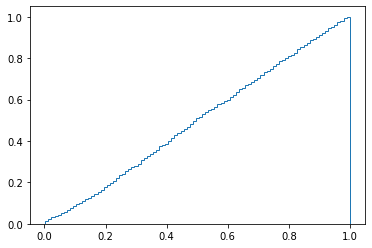

In [ ]:

plt.hist(pvals,99,cumulative=True,density=True, histtype='step')
plt.show()

In [ ]:
from scipy.stats import norm

norm.cdf(4.653643426357759)

0.9999983693971419